In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.3.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Essential info about tagged entities:

    o-geo = Geographical Entity
    o-org = Organization
    o-per = Person
    o-gpe = Geopolitical Entity
    o-tim = Time indicator
    o-art = Artifact
    o-eve = Event
    o-nat = Natural Phenomenon



In [34]:
data=pd.read_csv('/content/drive/My Drive/Colab Notebooks/data_sets_for_training/ner_dataset.csv',encoding='latin1')
data=data.fillna(method='ffill')
data.head(20)


# The first 20 is one sentence

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [35]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [37]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)
num_words

35179

In [38]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)
num_tags

17

we have 47958 sentences in our dataset, 35179 different words and 17 different named entities (Tags).

In [39]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [40]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [41]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [42]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [43]:
word2idx

{'Specialist': 1,
 'marathoner': 2,
 'multi-billion-dollar': 3,
 'carriages': 4,
 'registry': 5,
 'knife-wielding': 6,
 'Oo': 7,
 'Complaints': 8,
 'crossfire': 9,
 "al-U'Zayra": 10,
 'Revolution': 11,
 'Puebla': 12,
 'dissipate': 13,
 'identifying': 14,
 'Asset': 15,
 'Fijians': 16,
 'Rabin': 17,
 'declining': 18,
 'Tendulkar': 19,
 'Competition': 20,
 'convening': 21,
 'Hour': 22,
 'Diaz': 23,
 'dissipating': 24,
 'harmed': 25,
 'Ereli': 26,
 'Karo': 27,
 'Seismologists': 28,
 'springboard': 29,
 '80s': 30,
 '62': 31,
 'Every': 32,
 'English-speaking': 33,
 'Barre': 34,
 'Opel': 35,
 '230': 36,
 'catheter': 37,
 'Klebnikov': 38,
 'Bells': 39,
 'survey': 40,
 'findings': 41,
 'brook': 42,
 'deadline': 43,
 'announcement': 44,
 'internal': 45,
 'credited': 46,
 'Mashonaland': 47,
 'Tian': 48,
 'recommendation': 49,
 'Drinan': 50,
 'Exiles': 51,
 'Harriet': 52,
 'Cabeza': 53,
 'consensus': 54,
 'Concentration': 55,
 'curtains': 56,
 'Performing': 57,
 'Sergey': 58,
 'Graz': 59,
 'Bavari

In [44]:
tag2idx

{'B-art': 10,
 'B-eve': 5,
 'B-geo': 11,
 'B-gpe': 13,
 'B-nat': 8,
 'B-org': 4,
 'B-per': 9,
 'B-tim': 14,
 'I-art': 7,
 'I-eve': 0,
 'I-geo': 15,
 'I-gpe': 3,
 'I-nat': 6,
 'I-org': 2,
 'I-per': 16,
 'I-tim': 12,
 'O': 1}

In [46]:
largest_sen = max(len(sen) for sen in sent)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 104 words


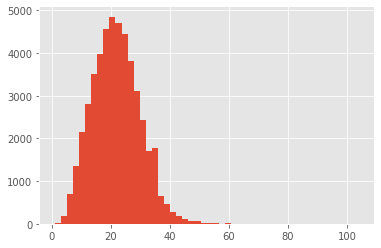

In [45]:
# find the distribution of length of sentences
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [ ]:
# In order to feed our sentences into a LSTM network, they all need to be the same size. looking at the distribution graph, we can set the 
# length of all sentences to 50 and add a generic word for the empty spaces; this process is called padding.

In [47]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])


In [48]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [49]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [50]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [53]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#from livelossplot.tf_keras import PlotLossesCallback

In [54]:
chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/3
1199/1199 [==============================] - ETA: 0s - loss: 0.1784 - accuracy: 0.9593
Epoch 00001: val_loss improved from inf to 0.06729, saving model to model_weights.h5
1199/1199 [==============================] - 580s 483ms/step - loss: 0.1784 - accuracy: 0.9593 - val_loss: 0.0673 - val_accuracy: 0.9808
Epoch 2/3
1199/1199 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9850
Epoch 00002: val_loss improved from 0.06729 to 0.05214, saving model to model_weights.h5
1199/1199 [==============================] - 572s 477ms/step - loss: 0.0505 - accuracy: 0.9850 - val_loss: 0.0521 - val_accuracy: 0.9844
Epoch 3/3
1199/1199 [==============================] - ETA: 0s - loss: 0.0370 - accuracy: 0.9886
Epoch 00003: val_loss improved from 0.05214 to 0.04771, saving model to model_weights.h5
1199/1199 [==============================] - 574s 478ms/step - loss: 0.0370 - accuracy: 0.9886 - val_loss: 0.0477 - val_accuracy: 0.9858


In [55]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 11s 37ms/step - loss: 0.0477 - accuracy: 0.9858


[0.04770501330494881, 0.9857693910598755]

In [56]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
At             O	O
least          O	O
eight          O	O
people         O	O
have           O	O
been           O	O
killed         O	O
in             O	O
the            O	O
fighting       O	O
.              O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast          O	O
coast     

In [59]:
my_sentence='Charls lives in London. He can speak fluent English'
word=my_sentence.split(' ')
word


['Charls', 'lives', 'in', 'London.', 'He', 'can', 'speak', 'fluent', 'English']

In [61]:
word2idx = {w: i + 1 for i, w in enumerate(word)}
word2idx

{'Charls': 1,
 'English': 9,
 'He': 5,
 'London.': 4,
 'can': 6,
 'fluent': 8,
 'in': 3,
 'lives': 2,
 'speak': 7}

In [89]:
x_list=[]
for key,value in word2idx.items():
  x_list.append(value)

while len(x_list)<50:
  x_list.append(num_words-1)

x_list=np.array(x_list)

x_list


array([    1,     2,     3,     4,     5,     6,     7,     8,     9,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178])

In [90]:
p = model.predict(np.array([x_list]))
p = np.argmax(p, axis=-1)
p

# 'Charls lives in London. He can speak fluent English'

array([[9, 1, 1, 1, 1, 1, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]])

In [91]:
tag2idx

{'B-art': 10,
 'B-eve': 5,
 'B-geo': 11,
 'B-gpe': 13,
 'B-nat': 8,
 'B-org': 4,
 'B-per': 9,
 'B-tim': 14,
 'I-art': 7,
 'I-eve': 0,
 'I-geo': 15,
 'I-gpe': 3,
 'I-nat': 6,
 'I-org': 2,
 'I-per': 16,
 'I-tim': 12,
 'O': 1}

In [94]:
entity_dict={}

for key,value in tag2idx.items():
  entity_dict[value]=key

entities=[]

for i in p[0]:
  entities.append(entity_dict[i])

entities




['B-per',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-org',
 'I-org',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']